<a href="https://colab.research.google.com/github/Errleng/chess-position-recognizer/blob/main/chess_piece_recognize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import sys
from google.colab import drive
mount_path = '/content/google-drive'
drive.mount(mount_path)
content_path = mount_path + '/MyDrive/colab-files/'
chess_pos_path = content_path + 'chess-positions/dataset/'
chess_pieces_path = content_path + 'chess-pieces/'
utils_path = content_path + 'utils/tensorflow_chessbot-chessfenbot/'

Mounted at /content/google-drive


In [5]:
# for local dataset
content_path = ''
chess_pos_path = content_path + 'chess-positions/'
chess_pieces_path = content_path + 'chess-pieces/'

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp /content/google-drive/MyDrive/colab-files/utils/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -p /content/google-drive/MyDrive/colab-files/chess-positions -d koryakinp/chess-positions

In [ ]:
!unzip /content/google-drive/MyDrive/colab-files/chess-positions/chess-positions.zip

In [7]:
# download directly here instead of Google Drive
!kaggle datasets download -d koryakinp/chess-positions

100% 4.00G/4.01G [01:15<00:00, 75.9MB/s]
100% 4.01G/4.01G [01:15<00:00, 57.3MB/s]


In [ ]:
!unzip chess-positions.zip "dataset/*" -d chess-positions/

In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import time
from pathlib import Path
import cv2
from google.colab.patches import cv2_imshow

FEN_CHAR_STRING = '1KQRBNPkqrbnp'
class_names = ['Empty',
               'White King', 'White Queen', 'White Rook',
               'White Bishop', 'White Knight', 'White Pawn',
               'Black King', 'Black Queen', 'Black Rook',
               'Black Bishop', 'Black Knight', 'Black Pawn']

print(tf.__version__)

2.6.0


In [ ]:
def generate_random_fen():
  default_info = ' w KQkq - 0 1'
  fen_square_chars = list(FEN_CHAR_STRING)
  fen = []
  for i in range(8):
    if i > 0:
      fen.append('/')
    fen += np.random.choice(fen_square_chars, 8).tolist()
  fen = ''.join(fen) + default_info
  return fen
print(f'Random FEN: {generate_random_fen()}')

In [10]:
def get_label_from_fen(fen, rank, file):
  piece_letter = None
  remaining_rank, remaining_file = rank, file
  for i in range(len(fen)):
    if remaining_rank > 0:
      if fen[i] == '/':
        remaining_rank -= 1
    else:
      if remaining_file == 0:
        if fen[i].isdigit():
          piece_letter = '1'
        else:
          piece_letter = fen[i]
        break
      if fen[i].isdigit():
        empty_squares = int(fen[i])
        if empty_squares > remaining_file:
          piece_letter = '1'
          break
        else:
          remaining_file -= empty_squares
      else:
        remaining_file -= 1
  piece_index = FEN_CHAR_STRING.find(piece_letter)
  # if piece_letter != '1':
  #   print(f'rank {rank} file {file} piece letter {piece_letter} with index {piece_index} at {fen}')
  return piece_index

def process_position(pos_image, fen):
  square_dim = 400//8
  squares = []
  labels = []
  parsed_fen = fen.replace('-', '/')
  for i in range(8):
    x_offset = i * square_dim
    for j in range(8):
      y_offset = j * square_dim
      square_image = pos_image[x_offset:x_offset + square_dim,
                                y_offset:y_offset + square_dim]
      square_image = cv2.cvtColor(square_image, cv2.COLOR_BGR2GRAY)                      
      squares.append(square_image)
      label = get_label_from_fen(parsed_fen, i, j)
      labels.append(label)
      # if label != 0:
      #   print(label, class_names[label], i, j, fen)
      #   cv2_imshow(square_image)
  return squares, labels

def write_squares_labels(output_path, pos_image, fen):
  square_dim = 400//8
  parsed_fen = fen.replace('-', '/')
  for i in range(8):
    x_offset = i * square_dim
    for j in range(8):
      y_offset = j * square_dim
      square_image = pos_image[x_offset:x_offset + square_dim,
                                y_offset:y_offset + square_dim]
      square_image = cv2.cvtColor(square_image, cv2.COLOR_BGR2GRAY)
      label = get_label_from_fen(parsed_fen, i, j)
      filename = f'{output_path}{fen}-fen-{i}-{j}-{label}.jpeg'
      cv2.imwrite(filename, square_image)

def write_images_labels(input_path, output_path, max_files=100, overwrite=False):
  count = 1
  path_in = Path(input_path)
  path_out = Path(output_path)
  path_out.mkdir(parents=True, exist_ok=True)

  existing_files = set()
  for file in path_out.iterdir():
    fen = re.search('^(.*)-fen-.*\.jpeg$', file.name).group(1)
    if fen not in existing_files:
      existing_files.add(fen)

  last_time = time.time()
  for file in path_in.iterdir():
    if count > max_files:
      break

    if time.time() - last_time > 10:
      last_time = time.time()
      print(f'Wrote {count} files from {input_path} to {output_path}')

    fen = re.search('^(.*)\.jpeg$', file.name).group(1)

    if not overwrite and fen in existing_files:
      continue

    image_path = input_path + file.name
    image = cv2.imread(image_path)    
    write_squares_labels(output_path, image, fen)

    count += 1

def get_images_labels_from_images(path, max_files=100):
  count = 1
  images, labels = [], []
  path_obj = Path(path)
  for file in path_obj.iterdir():
    if count > max_files:
      break

    image_path = path + file.name
    image = cv2.imread(image_path)
    fen = re.search('^(.*)\.jpeg$', file.name).group(1)
    square_images, square_labels = process_position(image, fen)

    images += square_images
    labels += square_labels
    count += 1
  return np.array(images), np.array(labels)

def get_images_labels(path, max_files=100):
  count = 1
  images, labels = [], []
  path_obj = Path(path)
  for file in path_obj.iterdir():
    if count > max_files:
      break
    image_path = path + file.name
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    label = int(re.search('^.*-(\d+)\.jpeg$', file.name).group(1))
    images.append(image)
    labels.append(label)
    count += 1
  return np.array(images), np.array(labels)

In [11]:
write_images_labels(chess_pos_path + 'train/', chess_pieces_path + 'train/', 10000)
write_images_labels(chess_pos_path + 'test/', chess_pieces_path + 'test/', 5000)

Wrote 900 files from dataset/train/ to chess-pieces/train/
Wrote 1793 files from dataset/train/ to chess-pieces/train/
Wrote 2294 files from dataset/train/ to chess-pieces/train/
Wrote 2829 files from dataset/train/ to chess-pieces/train/
Wrote 3599 files from dataset/train/ to chess-pieces/train/
Wrote 4478 files from dataset/train/ to chess-pieces/train/
Wrote 5285 files from dataset/train/ to chess-pieces/train/
Wrote 6091 files from dataset/train/ to chess-pieces/train/
Wrote 6865 files from dataset/train/ to chess-pieces/train/
Wrote 7631 files from dataset/train/ to chess-pieces/train/
Wrote 8404 files from dataset/train/ to chess-pieces/train/
Wrote 9089 files from dataset/train/ to chess-pieces/train/
Wrote 9753 files from dataset/train/ to chess-pieces/train/
Wrote 772 files from dataset/test/ to chess-pieces/test/
Wrote 1527 files from dataset/test/ to chess-pieces/test/
Wrote 2260 files from dataset/test/ to chess-pieces/test/
Wrote 3030 files from dataset/test/ to chess-pie

In [12]:
train_images, train_labels = get_images_labels(chess_pieces_path + 'train/', 100000)
test_images, test_labels = get_images_labels(chess_pieces_path + 'test/', 100000)
train_images = train_images / 255.0
test_images = test_images / 255.0
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(100000, 50, 50) (100000,)
(100000, 50, 50) (100000,)


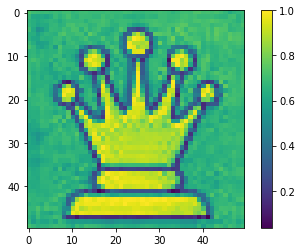

In [13]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

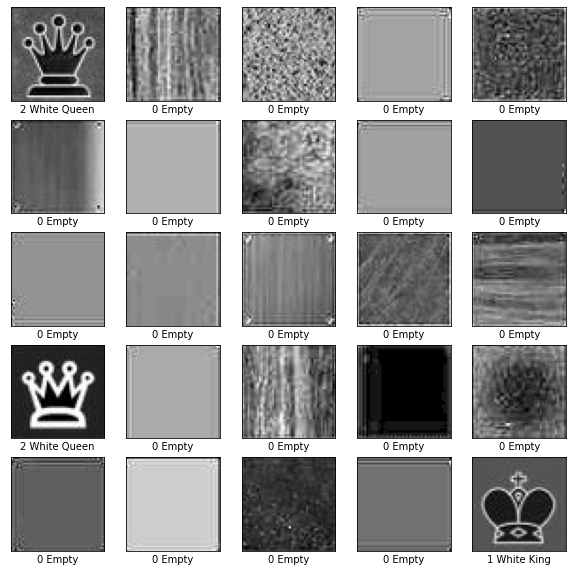

In [14]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(f'{train_labels[i]} {class_names[train_labels[i]]}')
    # plt.xlabel(class_names[np.where(train_labels[i] == 1)[0][0]])
plt.show()

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(50, 50)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(13)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
3125/3125 [==============================] - 11s 3ms/step - loss: 0.1549 - accuracy: 0.9632
Epoch 2/10
3125/3125 [==============================] - 8s 3ms/step - loss: 0.0631 - accuracy: 0.9859
Epoch 3/10
3125/3125 [==============================] - 8s 3ms/step - loss: 0.0249 - accuracy: 0.9926
Epoch 4/10
3125/3125 [==============================] - 8s 3ms/step - loss: 0.0308 - accuracy: 0.9923
Epoch 5/10
3125/3125 [==============================] - 8s 3ms/step - loss: 0.0140 - accuracy: 0.9955
Epoch 6/10
3125/3125 [==============================] - 8s 3ms/step - loss: 0.0188 - accuracy: 0.9960
Epoch 7/10
3125/3125 [==============================] - 8s 3ms/step - loss: 0.0115 - accuracy: 0.9966
Epoch 8/10
3125/3125 [==============================] - 8s 3ms/step - loss: 0.0246 - accuracy: 0.9959
Epoch 9/10
3125/3125 [==============================] - 8s 3ms/step - loss: 0.0083 - accuracy: 0.9973
Epoch 10/10
3125/3125 [==============================] - 8s 3ms/step - loss: 0.01

In [17]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

3125/3125 - 4s - loss: 0.0025 - accuracy: 0.9994

Test accuracy: 0.9993799924850464


In [18]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)

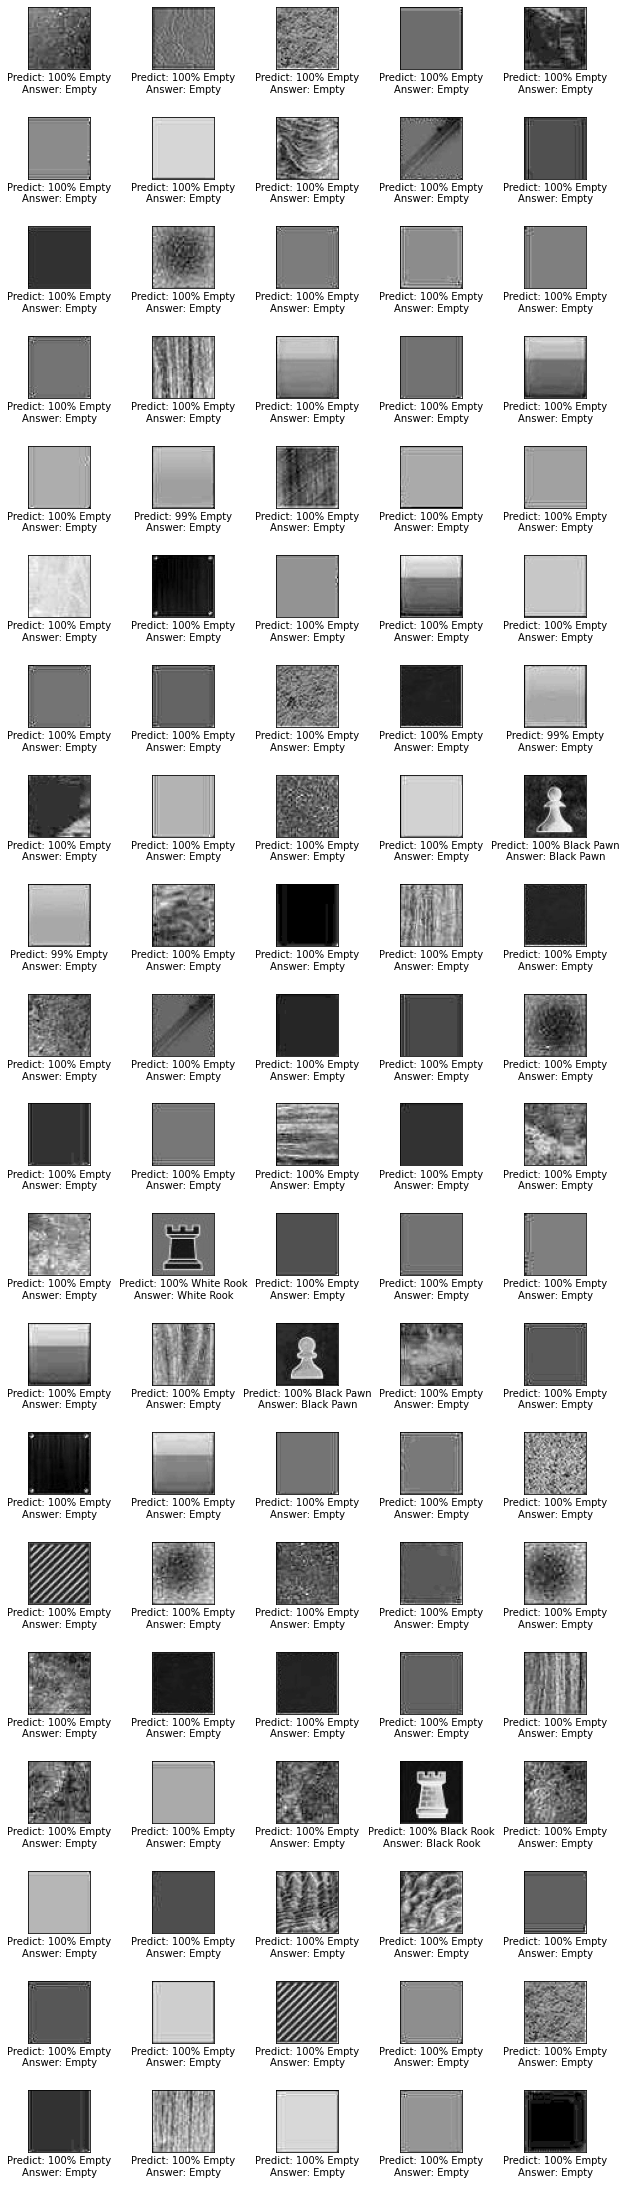

In [20]:
fen_chars = list(FEN_CHAR_STRING)

num_to_show = 100
width = 5
height = -(-num_to_show // width)

plt.figure(figsize=(10, 2 * height))
for i in range(min(num_to_show, len(predictions))):
  index = np.random.randint(0, len(predictions))
  p = predictions[index]
  img = test_images[i]

  pred = np.argmax(p)
  pred_confidence = np.max(predictions[index])
  pred_name = class_names[pred]
  actual_name = class_names[test_labels[index]]

  item_label = f'Predict: {100 * pred_confidence:2.0f}% {pred_name}\nAnswer: {actual_name}'

  plt.subplot(height, width, i+1)
  plt.subplots_adjust(wspace=1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(test_images[index], cmap=plt.cm.binary)
  plt.xlabel(item_label)